In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import random

import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read from Excel
pre_order_matrix = pd.read_excel("pre_order_matrix.xlsx", index_col=0)
stock_matrix = pd.read_excel("stock_matrix.xlsx", index_col=0)

# Dynamically find the number of warehouses based on the number of distance_matrix files
warehouses = ["W" + str(i) for i in range(1, len(stock_matrix.index) + 1)]
distance_matrix = {w: pd.read_excel("distance_matrix_" + w + ".xlsx", index_col=0) for w in warehouses}

In [3]:
# Dynamically find the number of customers and products based on pre_order_matrix's size
num_customers, num_products = pre_order_matrix.shape
print("Number of customers: ", num_customers)
print("Number of products: ", num_products)

# Dynamically find the number of warehouses based on cost_matrix's size
num_warehouses = len(distance_matrix)
print("Number of warehouses: ", num_warehouses)

Number of customers:  859
Number of products:  15
Number of warehouses:  10


In [4]:
# Convert data frames to dictionaries for Gurobi model
pre_order_dict = pre_order_matrix.stack().to_dict()
stock_dict = stock_matrix.stack().to_dict()
distance_dict = {w: distance_matrix[w].stack().to_dict() for w in warehouses}


In [10]:
distance_matrix

{'W1':       iThing1  iThing2  iThing3  iThing4  iThing5  iThing6  iThing7  iThing8  \
 C1        533      756      255      463      102      164      910      727   
 C2        867      156      154      227      632      771      749      905   
 C3        559      607      404       89      543      969      399      330   
 C4        849      319      259      242      856      700      208      296   
 C5        359      593      979      537      174      661      483      624   
 ...       ...      ...      ...      ...      ...      ...      ...      ...   
 C855      758      359      107      757      714      718      520       12   
 C856      626      248      666      565      852      383      839      869   
 C857      841      846      296      259      334       81      327      881   
 C858      576      624      639      350      710      480      527      866   
 C859      386      670      213       57      223      759      232      701   
 
       iThing9  iThi

In [6]:
# Create a new model
m = gp.Model("Apple_preorder_distribution")

# Create variables
x = m.addVars(warehouses, pre_order_matrix.index, pre_order_matrix.columns, vtype=GRB.INTEGER, name="x")

# # Set objective
# m.setObjective(gp.quicksum(x[w, c, p]*distance_dict[w][(c, p)] for w in warehouses for c in pre_order_matrix.index for p in pre_order_matrix.columns), GRB.MINIMIZE)

# # Add stock constraints
# m.addConstrs((gp.quicksum(x[w, c, p] for c in pre_order_matrix.index) <= stock_dict[(w, p)] for w in warehouses for p in pre_order_matrix.columns), "stock")

# # Add pre-order constraints
# m.addConstrs((gp.quicksum(x[w, c, p] for w in warehouses) == pre_order_dict[(c, p)] for c in pre_order_matrix.index for p in pre_order_matrix.columns), "preorder")

# # Optimize model
# m.optimize()

In [7]:
# Create a dictionary to hold results
results = {(w, p): 0 for w in warehouses for p in pre_order_matrix.columns}

# Iterate over the variables and collect the results
for v in m.getVars():
    if v.x > 0:
        w, c, p = v.varName.split('[')[1].split(']')[0].split(',')
        w = w.strip('\'')
        p = p.strip('\'')
        results[(w, p)] += v.x

# Display the results
for k, v in results.items():
    w, p = k
    print(f"From warehouse {w}, {v} units of product {p} were shipped.")


From warehouse W1, 208.0 units of product iThing1 were shipped.
From warehouse W1, 253.0 units of product iThing2 were shipped.
From warehouse W1, 99.0 units of product iThing3 were shipped.
From warehouse W1, 246.0 units of product iThing4 were shipped.
From warehouse W1, 184.0 units of product iThing5 were shipped.
From warehouse W1, 215.0 units of product iThing6 were shipped.
From warehouse W1, 220.0 units of product iThing7 were shipped.
From warehouse W1, 105.0 units of product iThing8 were shipped.
From warehouse W1, 245.0 units of product iThing9 were shipped.
From warehouse W1, 231.0 units of product iThing10 were shipped.
From warehouse W1, 236.0 units of product iThing11 were shipped.
From warehouse W1, 232.0 units of product iThing12 were shipped.
From warehouse W1, 230.0 units of product iThing13 were shipped.
From warehouse W1, 212.0 units of product iThing14 were shipped.
From warehouse W1, 276.0 units of product iThing15 were shipped.
From warehouse W2, 183.0 units of p

In [9]:
# Transform results into a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Shipment'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index)
results_df.index.names = ['Warehouse', 'Product']

# Create pivot table
pivot_df = results_df.reset_index().pivot(index='Warehouse', columns='Product', values='Shipment').fillna(0)

# Print table
display(pivot_df)

Product,iThing1,iThing10,iThing11,iThing12,iThing13,iThing14,iThing15,iThing2,iThing3,iThing4,iThing5,iThing6,iThing7,iThing8,iThing9
Warehouse,,,,,,,,,,,,,,,
W1,208.0,231.0,236.0,232.0,230.0,212.0,276.0,253.0,99.0,246.0,184.0,215.0,220.0,105.0,245.0
W10,205.0,259.0,194.0,250.0,223.0,138.0,231.0,187.0,195.0,253.0,183.0,237.0,274.0,276.0,252.0
W2,183.0,264.0,326.0,175.0,278.0,219.0,238.0,278.0,273.0,244.0,207.0,4.0,236.0,207.0,248.0
W3,226.0,227.0,11.0,254.0,222.0,210.0,201.0,283.0,43.0,184.0,304.0,238.0,230.0,242.0,182.0
W4,208.0,213.0,258.0,152.0,266.0,196.0,246.0,83.0,245.0,206.0,169.0,249.0,172.0,230.0,205.0
W5,227.0,124.0,230.0,279.0,203.0,186.0,252.0,115.0,244.0,219.0,185.0,234.0,245.0,275.0,187.0
W6,222.0,240.0,196.0,10.0,196.0,197.0,86.0,292.0,153.0,217.0,217.0,217.0,218.0,189.0,191.0
W7,201.0,218.0,231.0,249.0,224.0,222.0,189.0,245.0,287.0,77.0,184.0,254.0,163.0,256.0,190.0
W8,216.0,203.0,221.0,306.0,211.0,215.0,221.0,224.0,293.0,217.0,176.0,238.0,191.0,270.0,241.0


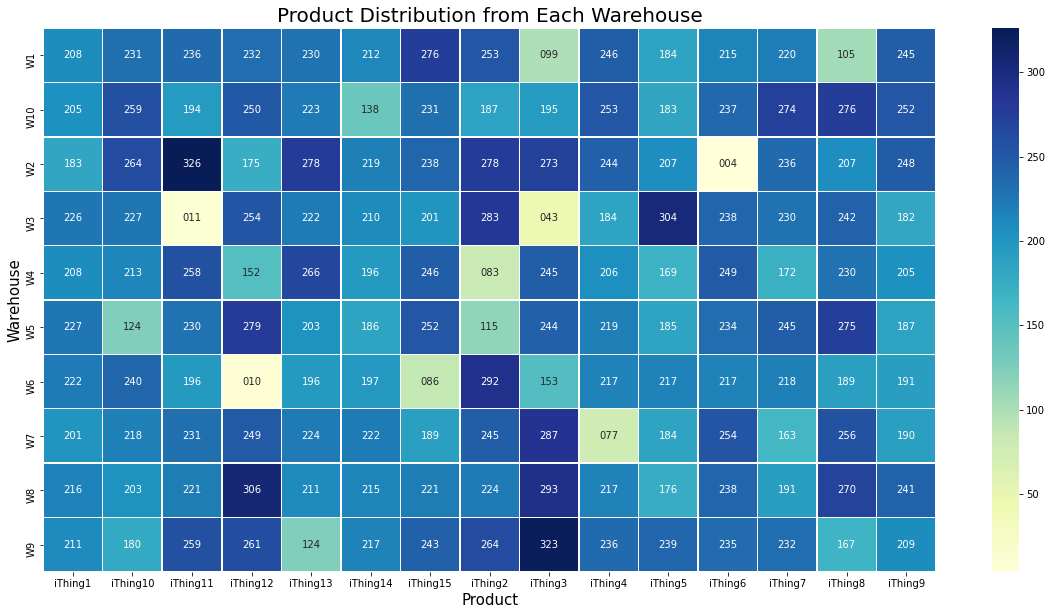

In [16]:
def fmt(x):
    return "{:03d}".format(int(x))

plt.figure(figsize=(20, 10))

# Create a 2D array of annotations
annotations = np.vectorize(fmt)(pivot_df.values)

sns.heatmap(pivot_df, cmap='YlGnBu', linewidths=.5, annot=annotations, fmt="", annot_kws={"size": 10})

plt.title('Product Distribution from Each Warehouse', fontsize=20)
plt.xlabel('Product', fontsize=15)
plt.ylabel('Warehouse', fontsize=15)

plt.show()